In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import logging
import os
import pickle
from pathlib import Path
from time import perf_counter

import numpy as np

from mcmc import MCMC
from mcmc.system import SurfaceSystem
from mcmc.utils import setup_logger
from mcmc.utils.misc import get_atoms_batch
from mcmc.utils.plot import plot_summary_stats

np.set_printoptions(precision=3, suppress=True)

Initialize pristine slab and parameters

In [3]:
# Initialize paths
surface_name = "SrTiO3(001)"
run_folder = Path() / surface_name
run_folder.mkdir(parents=True, exist_ok=True)

# Initialize logger
logger = setup_logger("mcmc", run_folder / "mc.log", logging.INFO)

# Clear jupyter notebook default handler
default_logger = logging.getLogger()
default_logger.handlers.clear()

# Load prepared pristine slab
try:
    with open("data/SrTiO3_001_2x2_pristine_slab.pkl", "rb") as f:
        slab = pickle.load(f)
except FileNotFoundError as e:
    print("Pristine surface pkl file not found. Please check you have downloaded the data.")
    raise e
offset_data_path = os.path.join(
    os.getcwd(),
    "data/nff",
    "offset_data.json",
)

try:
    with open(offset_data_path, "r") as f:
        offset_data = json.load(f)
except FileNotFoundError as e:
    print("Offset data file not found. Please check you have downloaded the data.")
    raise e

calc_settings = {
    "calc_name": "NFF",
    "optimizer": "BFGS",
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "relax_atoms": True,
    "relax_steps": 20,
    "offset": True,
    "offset_data": offset_data,
}

system_settings = {
    "surface_name": surface_name,
    "surface_depth": 1,
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
    "ads_site_type": "all",
}

sampling_settings = {
    "total_sweeps": 10,
    "sweep_size": 5,
    "start_temp": 1.0,  # in terms of kbT
    "perform_annealing": False,
    "alpha": 1.0,  # no annealing
    "adsorbates": list(calc_settings["chem_pots"].keys()),
    "run_folder": run_folder,
}

Set up NFF Calculator. Here, we are using the same neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file.

In [4]:
import torch
from nff.io.ase_calcs import NeuralFF
from nff.utils.cuda import cuda_devices_sorted_by_free_mem

from mcmc.calculators import EnsembleNFFSurface

DEVICE = f"cuda:{cuda_devices_sorted_by_free_mem()[-1]}" if torch.cuda.is_available() else "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_settings)

/home/dux/NeuralForceField/models
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters
chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


{'calc_name': 'NFF',
 'optimizer': 'BFGS',
 'chem_pots': {'Sr': -2, 'Ti': 0, 'O': 0},
 'relax_atoms': True,
 'relax_steps': 20,
 'offset': True,
 'offset_data': {'bulk_energies': {'O': -0.17747231201,
   'Sr': -0.06043637668,
   'SrTiO3': -1.470008697358702},
  'stoidict': {'Sr': 0.49995161381315867,
   'Ti': -0.0637500349111578,
   'O': -0.31241304903276834,
   'offset': -11.324476454433157},
  'stoics': {'Sr': 1, 'Ti': 1, 'O': 3},
  'ref_formula': 'SrTiO3',
  'ref_element': 'Ti'}}

Initialize surface system

In [5]:
slab_batch = get_atoms_batch(
    slab,
    system_settings["cutoff"],
    DEVICE,
    props={"energy": 0, "energy_grad": []},
)

surface = SurfaceSystem(
    slab_batch,
    calc=nff_surf_calc,
    system_settings=system_settings,
    save_folder=run_folder,
)
surface.all_atoms.write(run_folder / "SrTiO3_001_2x2_all_virtual_ads.cif")

13:28:10 - mcmc.system | INFO: Initalizing adsorption sites with settings: {'surface_name': 'SrTiO3(001)', 'surface_depth': 1, 'cutoff': 5.0, 'near_reduce': 0.01, 'planar_distance': 1.5, 'no_obtuse_hollow': True, 'ads_site_type': 'all'}


13:28:11 - mcmc.system | INFO: Generated adsorption coordinates are: [array([ 7.871,  7.941, 18.82 ]), array([ 1.968,  1.951, 18.779]), array([ 1.968,  0.146, 18.732]), array([ 7.871,  3.956, 18.82 ]), array([ 1.968,  5.936, 18.779])]...
13:28:11 - mcmc.system | INFO: Initializing 64 virtual atoms
13:28:11 - mcmc.system | INFO: Initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13:28:11 - mcmc.system | INFO: Number of pristine atoms is 60
13:28:11 - mcmc.system | INFO: Bulk indices are [ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 24 25 26 27
 28 29 30 31 32 33 34 35 36 39 40 41 42 43 44 45 46 47 48 49 50 51 54 55
 56 57 58 59]
13:28:11 - mcmc.system | INFO: Surface indices are [ 7  8 22 23 37 38 52 53]
13:28:11 - mcmc.system | INFO: Constraints are FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33

      Step     Time          Energy         fmax
BFGS:    0 13:28:11     -467.521881        0.2044
BFGS:    1 13:28:11     -467.525757        0.1803
BFGS:    2 13:28:11     -467.540619        0.0793
BFGS:    3 13:28:12     -467.540924        0.0598
BFGS:    4 13:28:12     -467.541351        0.0059


Calculate pristine surface energy

In [6]:
print(f"Surface energy {float(surface.get_surface_energy()):.3f} eV")

Surface energy 12.471 eV


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

In [7]:
mcmc = MCMC(**sampling_settings)

start = perf_counter()
results = mcmc.mcmc_run(
    surface=surface,
    **sampling_settings,
)
stop = perf_counter()
print(f"Time taken = {stop - start:.3f} seconds")

13:28:12 - mcmc.mcmc | INFO: Using run folder SrTiO3(001)
13:28:12 - mcmc.mcmc | INFO: There are 60 atoms in pristine slab
13:28:12 - mcmc.mcmc | INFO: Running with num_sweeps = 10, sweep_size = 5, start_temp = 1.000
13:28:12 - mcmc.mcmc | INFO: Starting with iteration 0
13:28:12 - mcmc.mcmc | INFO: Temperature schedule is: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
13:28:12 - mcmc.mcmc | INFO: In sweep 1 out of 10


      Step     Time          Energy         fmax
BFGS:    0 13:28:12     -468.047943       13.6444
BFGS:    1 13:28:12     -469.902222        4.2573
BFGS:    2 13:28:12     -470.302826        1.8483
BFGS:    3 13:28:12     -470.448517        0.9376
BFGS:    4 13:28:12     -470.502319        0.7842
BFGS:    5 13:28:12     -470.572266        0.4351
BFGS:    6 13:28:13     -470.611481        0.4490
BFGS:    7 13:28:13     -470.628204        0.6716
BFGS:    8 13:28:13     -470.381256        2.7001
BFGS:    9 13:28:13     -470.649261        0.6713
BFGS:   10 13:28:13     -470.659332        0.6413
BFGS:   11 13:28:13     -470.690948        0.5299
BFGS:   12 13:28:13     -470.701172        0.4642
BFGS:   13 13:28:13     -470.724457        0.2704
BFGS:   14 13:28:13     -470.727051        0.1378
BFGS:   15 13:28:13     -470.729492        0.1179
BFGS:   16 13:28:13     -470.730804        0.1328
BFGS:   17 13:28:14     -470.731598        0.1103
BFGS:   18 13:28:14     -470.732086        0.0591
B

13:28:24 - mcmc.system | INFO: Optimized structure has Energy = 8.498
13:28:24 - mcmc.mcmc | INFO: In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 13:28:24     -476.908203       26.0451
BFGS:    1 13:28:25     -481.881104       13.4925
BFGS:    2 13:28:25     -485.231415        7.1369
BFGS:    3 13:28:25     -487.211639        3.7530
BFGS:    4 13:28:25     -488.340729        2.2301
BFGS:    5 13:28:25     -488.973785        2.7576
BFGS:    6 13:28:25     -489.440155        2.6387
BFGS:    7 13:28:25     -489.918213        2.8930
BFGS:    8 13:28:25     -490.662506        2.7801
BFGS:    9 13:28:25     -491.368195        3.0246
BFGS:   10 13:28:25     -492.077423        3.5230
BFGS:   11 13:28:26     -492.597321        2.7397
BFGS:   12 13:28:26     -492.955353        2.1444
BFGS:   13 13:28:26     -493.502686        2.5334
BFGS:   14 13:28:26     -493.890778        2.3191
BFGS:   15 13:28:26     -494.466797        2.0209
BFGS:   16 13:28:26     -494.753082        2.2626
BFGS:   17 13:28:26     -495.117828        1.5299
BFGS:   18 13:28:26     -495.260101        1.0767
B

13:28:35 - mcmc.system | INFO: Optimized structure has Energy = 6.379
13:28:35 - mcmc.mcmc | INFO: In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 13:28:35     -483.059814       26.1953
BFGS:    1 13:28:36     -487.761627       13.5074
BFGS:    2 13:28:36     -491.263550        7.1662
BFGS:    3 13:28:36     -493.702881        3.8686
BFGS:    4 13:28:36     -495.258179        3.0906
BFGS:    5 13:28:36     -496.243011        3.2290
BFGS:    6 13:28:36     -497.129791        3.1102
BFGS:    7 13:28:36     -497.545807        4.4510
BFGS:    8 13:28:36     -498.112030        3.2021
BFGS:    9 13:28:36     -498.984528        2.4558
BFGS:   10 13:28:36     -499.282959        1.7901
BFGS:   11 13:28:36     -499.529419        1.8414
BFGS:   12 13:28:37     -499.694550        1.4758
BFGS:   13 13:28:37     -499.879303        1.3731
BFGS:   14 13:28:37     -500.002716        1.3253
BFGS:   15 13:28:37     -500.242157        1.7580
BFGS:   16 13:28:37     -500.511841        1.9880
BFGS:   17 13:28:37     -500.725616        1.9238
BFGS:   18 13:28:37     -500.882080        1.9907
B

13:28:46 - mcmc.system | INFO: Optimized structure has Energy = 6.379
13:28:46 - mcmc.mcmc | INFO: In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 13:28:46    34277.457031   814893.0380
BFGS:    1 13:28:46     -451.462494      491.8094
BFGS:    2 13:28:47     -459.894684      449.0253
BFGS:    3 13:28:47     -466.778229      383.2800
BFGS:    4 13:28:47     -472.834564      324.5349
BFGS:    5 13:28:47     -478.300690      248.9225
BFGS:    6 13:28:47     -484.264252      166.2955
BFGS:    7 13:28:47     -489.955292       58.2270
BFGS:    8 13:28:47     -489.838959       12.5128
BFGS:    9 13:28:47     -491.179169       14.8948
BFGS:   10 13:28:47     -489.794067      103.4144
BFGS:   11 13:28:48     -492.934601       14.1339
BFGS:   12 13:28:48     -493.646698       11.9229
BFGS:   13 13:28:48     -494.330048       25.1949
BFGS:   14 13:28:48     -495.192139        6.6750
BFGS:   15 13:28:48     -495.576660        9.7798
BFGS:   16 13:28:48     -495.800659       10.3153
BFGS:   17 13:28:48     -496.062256        9.8216
BFGS:   18 13:28:48     -496.201752       13.6140
B

13:28:57 - mcmc.system | INFO: Optimized structure has Energy = 1.112
13:28:57 - mcmc.mcmc | INFO: In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 13:28:57      946.414124    25611.0701
BFGS:    1 13:28:57     -432.210052      183.7327
BFGS:    2 13:28:57     -445.605103      176.8689
BFGS:    3 13:28:57     -460.937653      189.3758
BFGS:    4 13:28:57     -474.178619      183.1099
BFGS:    5 13:28:57     -481.577393      182.3149
BFGS:    6 13:28:57     -487.060822      143.1485
BFGS:    7 13:28:57     -489.531219      124.3790
BFGS:    8 13:28:57     -491.042236      105.6088
BFGS:    9 13:28:58     -492.014069       76.8720
BFGS:   10 13:28:58     -493.160248       49.0307
BFGS:   11 13:28:58     -493.944183       26.4006
BFGS:   12 13:28:58     -494.238434        9.5745
BFGS:   13 13:28:58     -494.572754        3.4198
BFGS:   14 13:28:58     -494.844025        9.4267
BFGS:   15 13:28:58     -495.036530        3.9719
BFGS:   16 13:28:58     -495.239105        1.2926
BFGS:   17 13:28:58     -495.352539        3.9732
BFGS:   18 13:28:58     -495.562622        9.2202
B

13:29:07 - mcmc.system | INFO: Optimized structure has Energy = 1.485
13:29:07 - mcmc.mcmc | INFO: In sweep 6 out of 10


      Step     Time          Energy         fmax
BFGS:    0 13:29:07     -401.965851      164.6813
BFGS:    1 13:29:07     -439.808746       54.7779
BFGS:    2 13:29:07     -468.181000       55.9168
BFGS:    3 13:29:07     -378.287506     1690.6704
BFGS:    4 13:29:07     -482.735687       21.1253
BFGS:    5 13:29:08     -487.958160       13.6939
BFGS:    6 13:29:08     -493.092621       35.5128
BFGS:    7 13:29:08     -496.843414        6.8245
BFGS:    8 13:29:08     -498.835541        4.0780
BFGS:    9 13:29:08     -500.326080        3.5614
BFGS:   10 13:29:08     -501.437256        5.3738
BFGS:   11 13:29:08     -502.307220        2.2207
BFGS:   12 13:29:08     -503.226318        2.0684
BFGS:   13 13:29:08     -503.413818        3.4293
BFGS:   14 13:29:08     -503.811554        7.7491
BFGS:   15 13:29:09     -504.123413        8.4771
BFGS:   16 13:29:09     -504.283813        5.4662
BFGS:   17 13:29:09     -504.376709        3.4888
BFGS:   18 13:29:09     -504.425812        2.4183
B

13:29:18 - mcmc.system | INFO: Optimized structure has Energy = 1.485
13:29:18 - mcmc.mcmc | INFO: In sweep 7 out of 10


      Step     Time          Energy         fmax
BFGS:    0 13:29:18       81.393280     9082.4631
BFGS:    1 13:29:18     -440.911591       93.3955
BFGS:    2 13:29:18     -460.407623       56.7604
BFGS:    3 13:29:18     -475.064301       23.9021
BFGS:    4 13:29:18     -488.554810       19.9031
BFGS:    5 13:29:18     -499.870209       16.6765
BFGS:    6 13:29:18     -506.337006        9.6262
BFGS:    7 13:29:18     -509.250488        4.5742
BFGS:    8 13:29:19     -510.586945        2.8623
BFGS:    9 13:29:19     -511.419769        2.7623
BFGS:   10 13:29:19     -512.583557        2.6725
BFGS:   11 13:29:19     -513.467773        3.3326
BFGS:   12 13:29:19     -514.308960        3.6455
BFGS:   13 13:29:19     -514.925842        5.1628
BFGS:   14 13:29:19     -515.351013        1.8047
BFGS:   15 13:29:19     -515.647461        1.4150
BFGS:   16 13:29:19     -516.362000        3.6715
BFGS:   17 13:29:20     -516.614441        2.0203
BFGS:   18 13:29:20     -516.799622        1.1369
B

13:29:29 - mcmc.system | INFO: Optimized structure has Energy = -0.781
13:29:29 - mcmc.mcmc | INFO: In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 13:29:29     1777.943726    29849.6874
BFGS:    1 13:29:30     -308.686737     1174.1878
BFGS:    2 13:29:30     -371.018768      123.9808
BFGS:    3 13:29:30     -430.864166      132.8653
BFGS:    4 13:29:30     -154.264938     4993.1609
BFGS:    5 13:29:30     -393.773041     1234.2818
BFGS:    6 13:29:30     -470.042328      119.9151
BFGS:    7 13:29:30     -486.465973       22.6766
BFGS:    8 13:29:30     -492.701813       93.1547
BFGS:    9 13:29:30     -499.322296       13.9665
BFGS:   10 13:29:31     -501.929321       12.8372
BFGS:   11 13:29:31     -503.735626        3.4413
BFGS:   12 13:29:31     -505.174469        3.8566
BFGS:   13 13:29:31     -506.425385        4.0058
BFGS:   14 13:29:31     -507.531342        9.8214
BFGS:   15 13:29:31     -508.518280       12.4433
BFGS:   16 13:29:31     -508.979126        5.3881
BFGS:   17 13:29:31     -509.631805        5.5042
BFGS:   18 13:29:31     -510.019196        7.5246
B

13:29:41 - mcmc.system | INFO: Optimized structure has Energy = -0.781
13:29:41 - mcmc.mcmc | INFO: In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 13:29:41      180.930130     9071.0996
BFGS:    1 13:29:41     -343.659668      178.1964
BFGS:    2 13:29:41      425.303101    14341.4761
BFGS:    3 13:29:41      -39.773022     6775.0997
BFGS:    4 13:29:41     -402.774139     1091.9287
BFGS:    5 13:29:41     -449.070557      445.2496
BFGS:    6 13:29:41     -472.026947      326.0755
BFGS:    7 13:29:42     -492.727692       74.1110
BFGS:    8 13:29:42     -487.348114      186.8097
BFGS:    9 13:29:42     -503.982880       36.9798
BFGS:   10 13:29:42     -508.985962        6.2570
BFGS:   11 13:29:42     -511.404877       25.5253
BFGS:   12 13:29:42     -513.210266       18.5494
BFGS:   13 13:29:42     -514.850403       21.3781
BFGS:   14 13:29:42     -516.402832       17.4662
BFGS:   15 13:29:42     -517.764587        6.2283
BFGS:   16 13:29:43     -518.360107        5.6128
BFGS:   17 13:29:43     -519.018250        5.4834
BFGS:   18 13:29:43     -519.776428        7.0873
B

13:29:52 - mcmc.system | INFO: Optimized structure has Energy = -0.781
13:29:52 - mcmc.mcmc | INFO: In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 13:29:52    34933.027344   814935.9425
BFGS:    1 13:29:52      153.940506     8382.1191
BFGS:    2 13:29:52     -329.893890      382.0219
BFGS:    3 13:29:52     -384.413940      360.2601
BFGS:    4 13:29:53     -430.530670      133.1634
BFGS:    5 13:29:53     -455.541504       41.8758
BFGS:    6 13:29:53     -464.433960      213.9424
BFGS:    7 13:29:53     -484.595367       72.8653
BFGS:    8 13:29:53     -493.870239       27.8502
BFGS:    9 13:29:53     -498.285400       18.7938
BFGS:   10 13:29:53     -500.633820        8.8589
BFGS:   11 13:29:53     -502.143646        5.0811
BFGS:   12 13:29:53     -503.695312        8.3804
BFGS:   13 13:29:53     -504.986328        3.6382
BFGS:   14 13:29:54     -505.955902        2.7022
BFGS:   15 13:29:54     -506.490112        5.1296
BFGS:   16 13:29:54     -507.229401       16.6551
BFGS:   17 13:29:54     -507.812866        7.9860
BFGS:   18 13:29:54     -508.467682        2.6327
B

13:30:03 - mcmc.system | INFO: Optimized structure has Energy = -0.781


Time taken = 111.175 seconds


Plot results

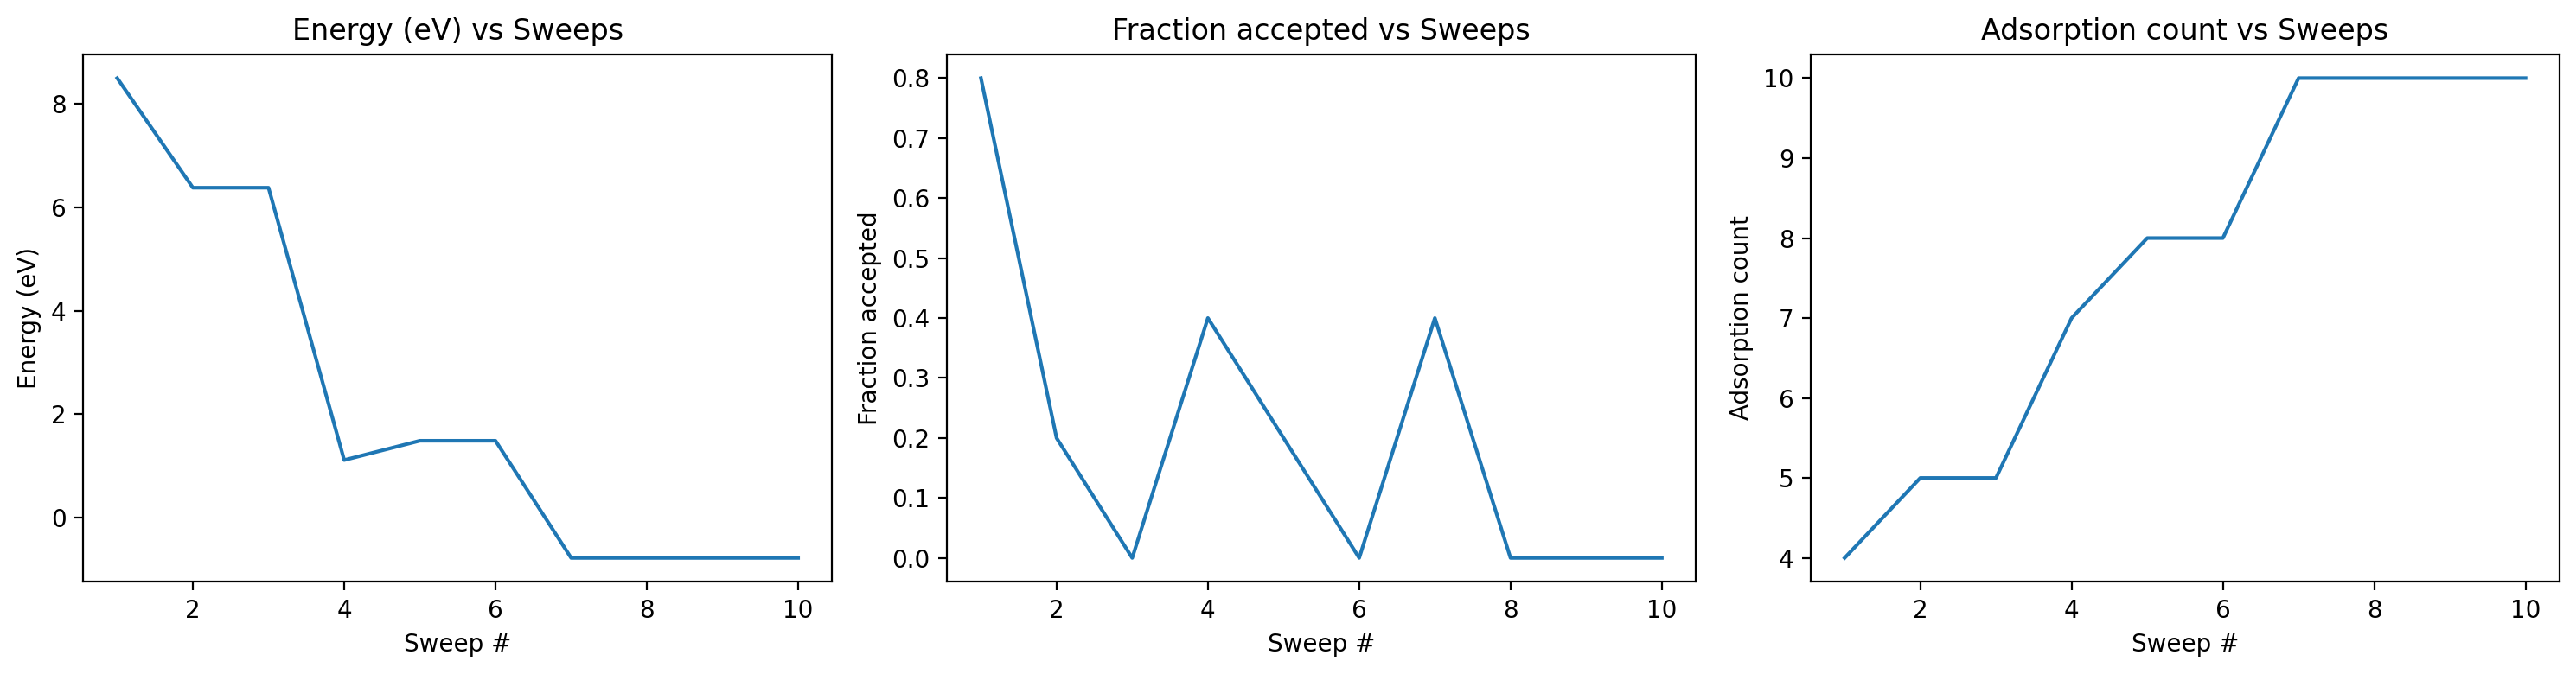

In [8]:
fig = plot_summary_stats(
    results["energy_hist"],
    results["frac_accept_hist"],
    results["adsorption_count_hist"],
    sampling_settings["total_sweeps"],
    save_folder=run_folder,
)

Save structures for later use in latent space clustering or analysis

In [9]:
structures = results["history"]
with open("data/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)